In [1]:
!pip install konlpy

In [2]:
import json
import re
from konlpy.tag import Okt
from collections import Counter
from wordcloud import WordCloud
from functools import reduce

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
import matplotlib.font_manager as fm
font_loc = 'C:/Windows/Fonts/H2PORM.TTF'
font_name = fm.FontProperties(fname=font_loc).get_name()
matplotlib.rc('font',family=font_name)
plt.rcParams['axes.unicode_minus'] = False  # 한글폰트적용시 - 깨짐방지..

In [3]:
df = pd.read_csv('used.csv')

In [4]:
df = df.iloc[:,1:]
df.head()

,create_date,price,text,phone_model,factory_price,maker,price_index
0,2017-03-19 4 35 00 PM,550000.0,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...,iphone 6 64gb,924000,apple,95.96
1,2016-10-26 12 08 00 PM,380000.0,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...,galaxy s6 edge 32gb,979000,samsung,103.05
2,2016-10-25 12 52 00 PM,300000.0,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...,galaxy s6 32gb,854000,samsung,103.05
3,2017-03-23 11 14 00 PM,290000.0,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...,lg g5 32gb,836000,lg,95.96
4,2016-04-11 7 35 00 PM,280000.0,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...,lg u 32gb,396000,lg,102.59


In [5]:
# 모델과 가격 but 뎃글을 분석해서 가격을 예측을 시도

In [6]:
# price_index : 판매지수

In [7]:
# 데이터 탐색
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4951 entries, 0 to 4950
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   create_date    4951 non-null   object 
 1   price          4951 non-null   float64
 2   text           4951 non-null   object 
 3   phone_model    4951 non-null   object 
 4   factory_price  4951 non-null   int64  
 5   maker          4951 non-null   object 
 6   price_index    4951 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 270.9+ KB


In [8]:
df.describe()

,price,factory_price,price_index
count,4.951000e+03,4.951000e+03,4951.000000
mean,3.266164e+05,8.358315e+05,100.915336
std,2.169753e+05,1.991910e+05,3.245415
min,1.500000e+04,1.540000e+05,94.900000
25%,1.400000e+05,7.898000e+05,95.960000
50%,3.000000e+05,9.042000e+05,103.050000
75%,4.500000e+05,9.240000e+05,103.050000
max,1.500000e+06,1.283700e+06,103.050000


<AxesSubplot:xlabel='count'>

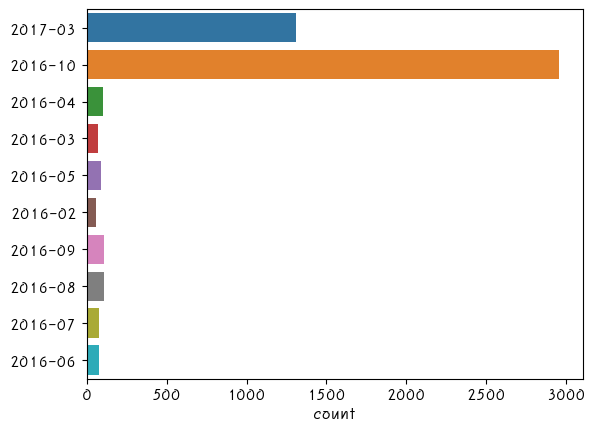

In [9]:
# create_date 를 통해서 거래가 활발히 이루어지는(등록) 특정 날자구간을 구할수 있다.
temp = df.create_date.str.strip().apply(lambda x : x[:7])
sns.countplot(data=temp, y=temp.values)

<AxesSubplot:xlabel='price', ylabel='Count'>

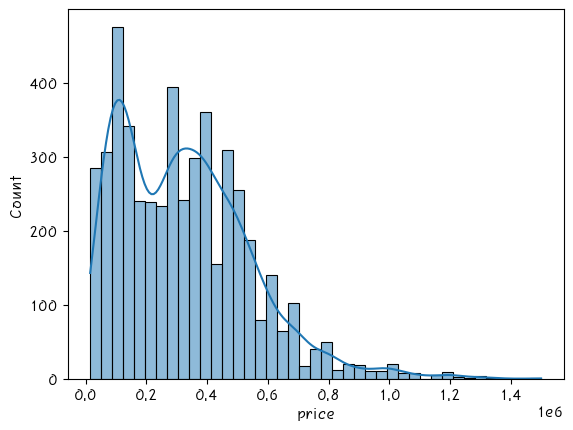

In [10]:
# 가격분포.
sns.histplot(data=df, x='price',kde=True)

In [11]:
df.head(1)

,create_date,price,text,phone_model,factory_price,maker,price_index
0,2017-03-19 4 35 00 PM,550000.0,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...,iphone 6 64gb,924000,apple,95.96


In [12]:
# 표준화  z-score  음수면 평균이하... 양수면 평균이상
#  평균이 0이고 표준편차가 1인 표준정규분포로 환산해서 비교하는 점수
# 모델별 가격분포
df.groupby(['phone_model'])['price'].mean().sort_values(ascending=False)
# 해당 거래의 가격이 기종별 평균에 비해서 높고 낮은지를 확인

phone_model
iphone 7 256gb           1.072353e+06
iphone 7 plus 256gb      1.067273e+06
iphone 7 plus 128gb      8.334286e+05
iphone 7 128gb           8.010000e+05
iphone 7 32gb            7.043750e+05
                             ...     
g pro2 32gb              9.014286e+04
galaxy s4 lte-a 32gb     8.933333e+04
galaxy grand max 16gb    8.808571e+04
galaxy note3 neo 16gb    8.725806e+04
lg g2 32gb               6.277778e+04
Name: price, Length: 64, dtype: float64

In [13]:
# 표준화 z-score  값을 - 평균 / 표준편차

In [14]:
# df.groupby(['phone_model'])['price'].mean()
df['model_mean'] = df.groupby(['phone_model'])['price'].transform('mean')
df['model_std'] = df.groupby(['phone_model'])['price'].transform('std')
df['model_z'] = (df['price'] - df['model_mean']) / df['model_std']

In [15]:
df.head(1)

,create_date,price,text,phone_model,factory_price,maker,price_index,model_mean,model_std,model_z
0,2017-03-19 4 35 00 PM,550000.0,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...,iphone 6 64gb,924000,apple,95.96,454523.974052,136150.876923,0.701252


In [16]:
df[df['phone_model'] == 'g pro2 32gb']

,create_date,price,text,phone_model,factory_price,maker,price_index,model_mean,model_std,model_z
127,2016-10-10 10 53 00 PM,35000.0,지프로2 부품폰 팝니다 \n\t ...,g pro2 32gb,999000,lg,103.05,90142.857143,24629.182663,-2.238924
130,2016-10-24 2 38 00 PM,40000.0,"지프로2 gpro2, 4만원, 악세사리포함 지프로2 gpro2, 4만원, 악세사리...",g pro2 32gb,999000,lg,103.05,90142.857143,24629.182663,-2.035912
190,2016-10-23 8 53 00 PM,40000.0,"지프로2 + 커버 등 4만원 와이파이 안됨, 서울 흑석동 \n\t ...",g pro2 32gb,999000,lg,103.05,90142.857143,24629.182663,-2.035912
223,2016-10-15 11 07 00 PM,50000.0,"g프로2, 지프로2 삽니다 구성품과 상태 적어서 보내주시거나 사진 보내주시면 답장...",g pro2 32gb,999000,lg,103.05,90142.857143,24629.182663,-1.629890
448,2017-03-18 11 49 00 AM,70000.0,판매완료 gpro2 지프로2 24기가 7만원 b급 직접거래 다른 폰도 판매중이니 ...,g pro2 32gb,999000,lg,95.96,90142.857143,24629.182663,-0.817845
449,2017-03-18 12 16 00 PM,70000.0,판매완료 gpro2 지프로2 24기가 7만원 b급 직접거래 다른 폰도 판매중이니 ...,g pro2 32gb,999000,lg,95.96,90142.857143,24629.182663,-0.817845
477,2016-10-21 8 02 00 PM,80000.0,lgu+ g pro2 지프로2 화이트 판매합니다 \n\t ...,g pro2 32gb,999000,lg,103.05,90142.857143,24629.182663,-0.411823
478,2016-10-22 11 41 00 AM,80000.0,lgu+ gpro2 지프로2 화이트 판매합니다 \n\t ...,g pro2 32gb,999000,lg,103.05,90142.857143,24629.182663,-0.411823
479,2017-03-22 9 11 00 PM,80000.0,lgu+ gpro2 지프로2 화이트 판매합니다 \n\t ...,g pro2 32gb,999000,lg,95.96,90142.857143,24629.182663,-0.411823
517,2017-03-24 9 51 00 AM,80000.0,"skt lg g pro 2 지프로2 8만원 팝니다 배터리, 케이스, 거치대 포함 ...",g pro2 32gb,999000,lg,95.96,90142.857143,24629.182663,-0.411823


<AxesSubplot:xlabel='model_z', ylabel='Count'>

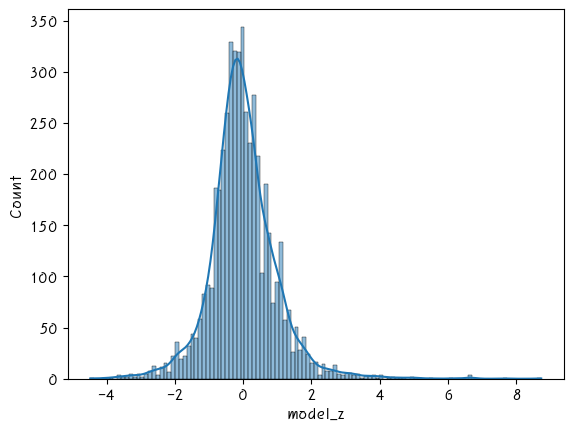

In [17]:
sns.histplot(data=df,x='model_z',kde=True)

<AxesSubplot:xlabel='maker', ylabel='price'>

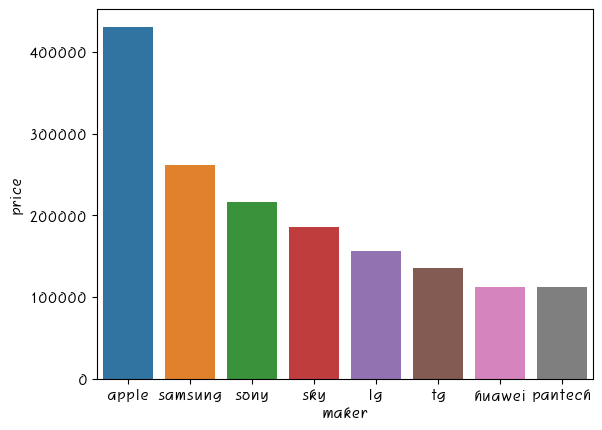

In [18]:
# 제조사별 중고거래 평균 가격
temp = df.groupby(['maker'])['price'].mean()
temp2 = temp.reset_index()
temp2 = temp2.sort_values(by='price', ascending=False)
sns.barplot(data=temp2, x = 'maker', y= 'price')
# 연도별 제조사별 평균거래 가격
# 모델을 좀더 세분화.... 새로운 컬럼에 
# 가격에 영향을 미치는 요인을 찾아봅시다

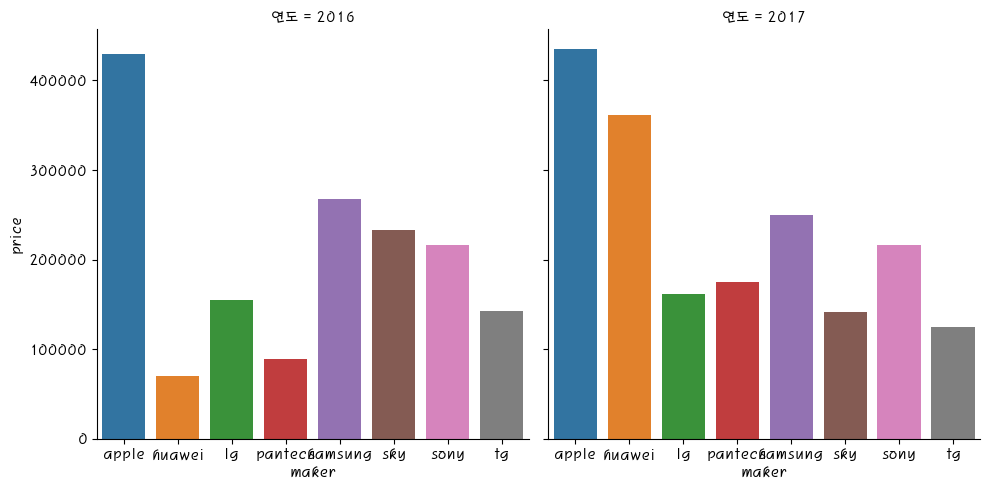

In [19]:
# 연도별 제조사별 평균거래 가격
df['연도'] = df['create_date'].apply(lambda x : x[:4])
temp = df.groupby(['연도','maker'])['price'].mean()
temp = temp.reset_index()
temp
# sns.lineplot(data=temp,x='연도',y='price',hue='maker')
# plt.legend(bbox_to_anchor=(1,1))
# plt.show()
sns.catplot(data=temp,x='maker',y='price', col='연도', col_wrap=2,kind='bar')

In [20]:
# 뎃글읠 단어분석을 통해서 가격에 미치는 요인이있는지 확인

In [21]:
# 상관관계 시각화.... 중고거래 가격에 미치는 요인들...
df.corr()

,price,factory_price,price_index,model_mean,model_std,model_z
price,1.000000,0.339306,0.025516,8.366462e-01,4.834945e-01,5.058560e-01
factory_price,0.339306,1.000000,-0.011648,4.044477e-01,1.614838e-01,1.579936e-03
price_index,0.025516,-0.011648,1.000000,-3.590601e-02,1.993732e-02,1.132911e-01
model_mean,0.836646,0.404448,-0.035906,1.000000e+00,5.778959e-01,-7.653717e-16
model_std,0.483494,0.161484,0.019937,5.778959e-01,1.000000e+00,-1.218798e-15
model_z,0.505856,0.001580,0.113291,-7.653717e-16,-1.218798e-15,1.000000e+00


<AxesSubplot:>

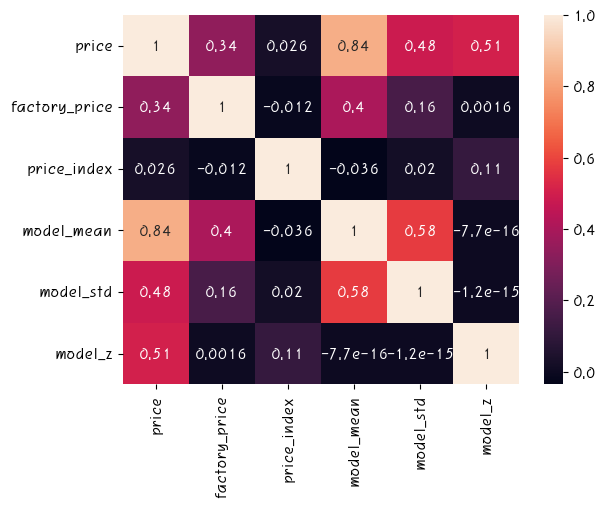

In [22]:
sns.heatmap(data=df.corr(),annot=True)

In [23]:
df.head(1)

,create_date,price,text,phone_model,factory_price,maker,price_index,model_mean,model_std,model_z,연도
0,2017-03-19 4 35 00 PM,550000.0,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...,iphone 6 64gb,924000,apple,95.96,454523.974052,136150.876923,0.701252,2017


In [24]:
# 공장도 가격은 중고거래에 영향을 안 미친다..

In [25]:
df['phone_model'].unique()
# split을 한 다음 마지막게 submodel  main_model


array(['iphone 6 64gb', 'galaxy s6 edge 32gb', 'galaxy s6 32gb',
       'lg g5 32gb', 'lg u 32gb', 'galaxy a7 2016 16gb',
       'galaxy note 2 32gb', 'g4 32gb', 'wine smart jazz 4gb',
       'galaxy s4 32gb', 'g3 cat.6 32gb', 'iphone 7 128gb',
       'iphone 6 16gb', 'vega iron2 32gb', 'optimus g 32gb',
       'galaxy s3 3g 8gb', 'galaxy alpha 32gb', 'galaxy note3 32gb',
       'lg g2 32gb', 'galaxy note3 neo 16gb', 'vega secret up 16gb',
       'galaxy note7 64gb', 'y6 8gb', 'galaxy note4 32gb',
       'iphone 5 16gb', 'g pro2 32gb', 'iphone 4s 16gb', 'galaxy s5 32gb',
       'galaxy grand max 16gb', 'luna 16gb', 'iphone se 64gb',
       'iphone 6s Plus 64gb', 'galaxy s4 lte-a 32gb', 'galaxy folder 8gb',
       'xperia z3 16gb', 'iphone 4s 32gb', 'im-100 32gb',
       'iphone 5s 16gb', 'galaxy note3 16gb', 'galaxy s7 32gb',
       'galaxy s6 64gb', 'galaxy s6 edge plus 32gb',
       'galaxy s7 edge 32gb', 'nexus 5x 16gb', 'iphone 6 128gb',
       'iphone 7 plus 128gb', 'iphone 6 32gb

In [26]:
#phone_model - model  submodel
df['submodel'] = df.phone_model.str.split().apply(lambda x : x[-1])
df['model'] = df.phone_model.str.split().apply(lambda x : " ".join( x[:-1]))
df.tail()

,create_date,price,text,phone_model,factory_price,maker,price_index,model_mean,model_std,model_z,연도,submodel,model
4946,2016-10-10 11 29 00 AM,1300000.0,미개봉 언락폰 아이폰7플러스 256gb 골드 iphone7 plus 강북 도봉\t ...,iphone 7 plus 256gb,1283700,apple,103.05,1.067273e+06,199202.957262,1.168292,2016,256gb,iphone 7 plus
4947,2016-10-24 10 03 00 PM,1300000.0,미국판 아이폰7 256g 제트블랙 강남역삼 2대 미개봉언락 애플 a1660 강남역삼...,iphone 7 256gb,1130800,apple,103.05,1.072353e+06,177536.243193,1.282257,2016,256gb,iphone 7
4948,2016-09-19 10 15 00 AM,1300000.0,"아이폰7 미개봉 홍콩판 팝니다 케이스,강화유리서비스 종류다양 아이폰7 917,91...",iphone 7 256gb,1130800,apple,103.05,1.072353e+06,177536.243193,1.282257,2016,256gb,iphone 7
4949,2016-10-05 12 22 00 AM,1350000.0,미개봉 언락폰 아이폰7플러스 256gb 골드 iphone7 plus 강북 도봉 미개...,iphone 7 plus 256gb,1283700,apple,103.05,1.067273e+06,199202.957262,1.419293,2016,256gb,iphone 7 plus
4950,2016-09-26 11 37 00 AM,1500000.0,"팝니다 아이폰 7 128gb 제트블랙 북미판 카메라 무음, 국내리퍼 가능 1...",iphone 7 128gb,999000,apple,103.05,8.010000e+05,215526.575033,3.243220,2016,128gb,iphone 7


<AxesSubplot:xlabel='count', ylabel='model'>

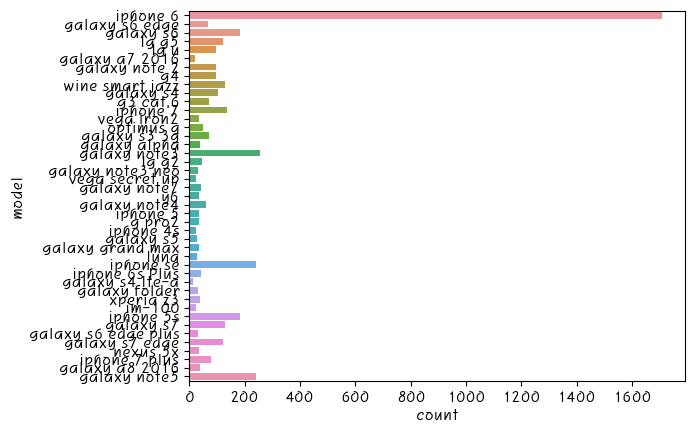

In [27]:
# 모델별 거래량.
sns.countplot(data=df ,y='model')

<AxesSubplot:xlabel='count', ylabel='model'>

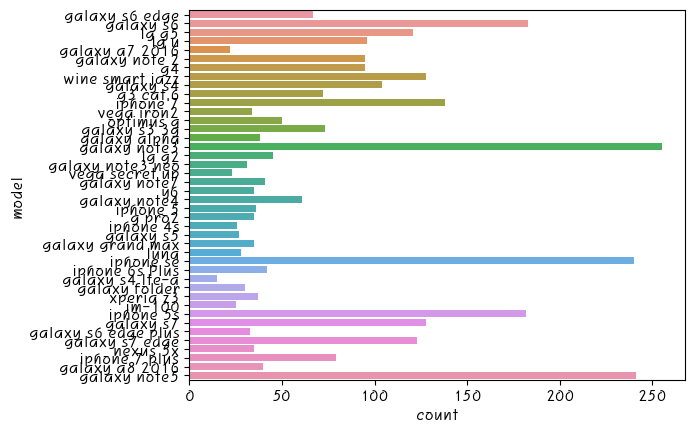

In [28]:
sns.countplot(data=df[df.model != 'iphone 6'] ,y='model')
# sns.countplot(data=df ,y='model')

C:\Users\user\miniconda3\lib\site-packages\seaborn\categorical.py:3199: UserWarning: Setting `sharey=False` with `color=None` may cause different levels of the `y` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharey", "y"), UserWarning)


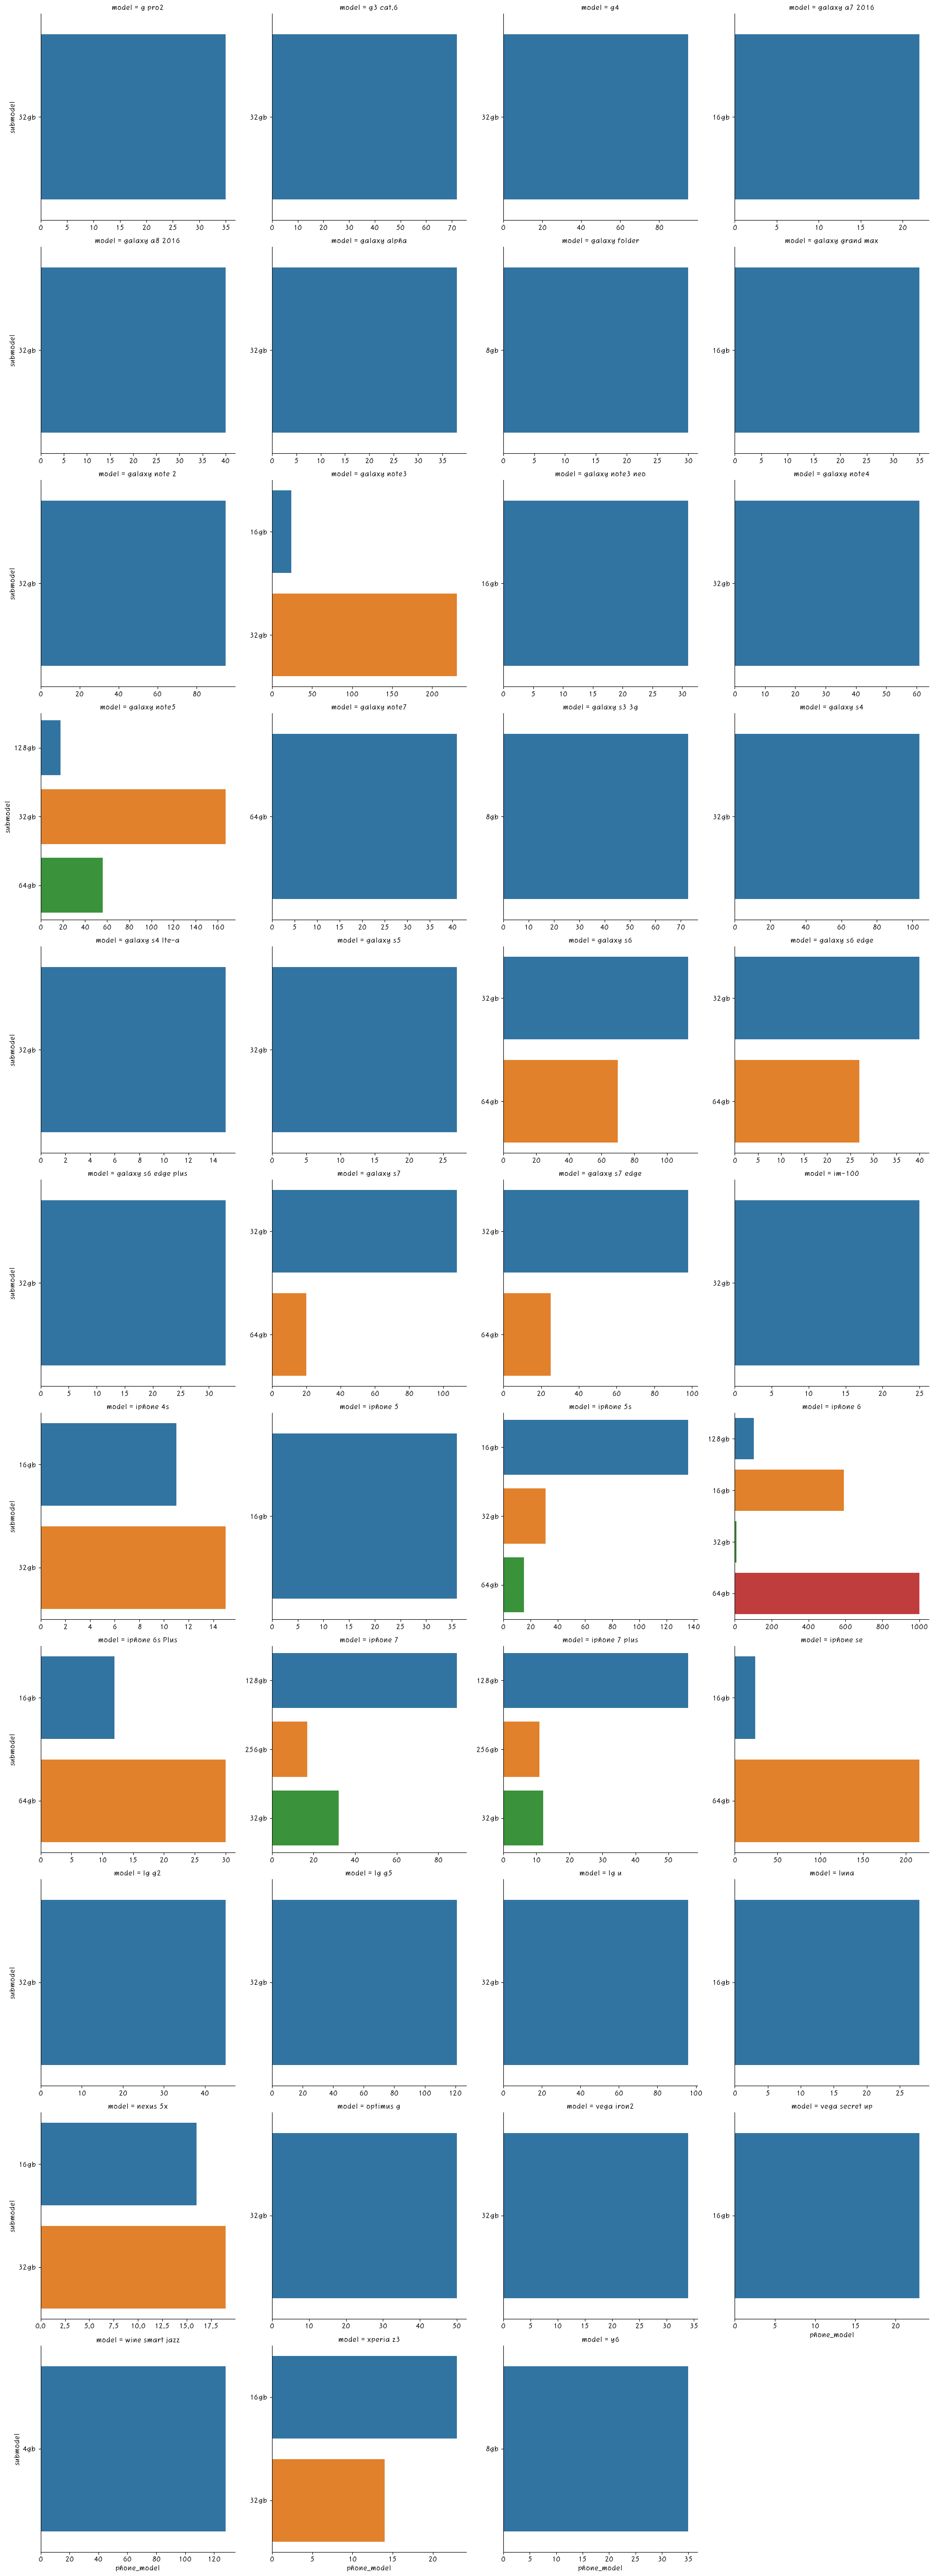

In [29]:
# 모델별 하위모델별 거래량
temp = df.groupby(['model','submodel'])['phone_model'].count()
temp = temp.reset_index()
temp
# sns.barplot(data=temp, x = 'phone_model', y='model', hue='submodel')
sns.catplot(data=temp, y='submodel',x='phone_model',col = 'model',col_wrap=4,kind='bar',sharey=False,sharex=False)

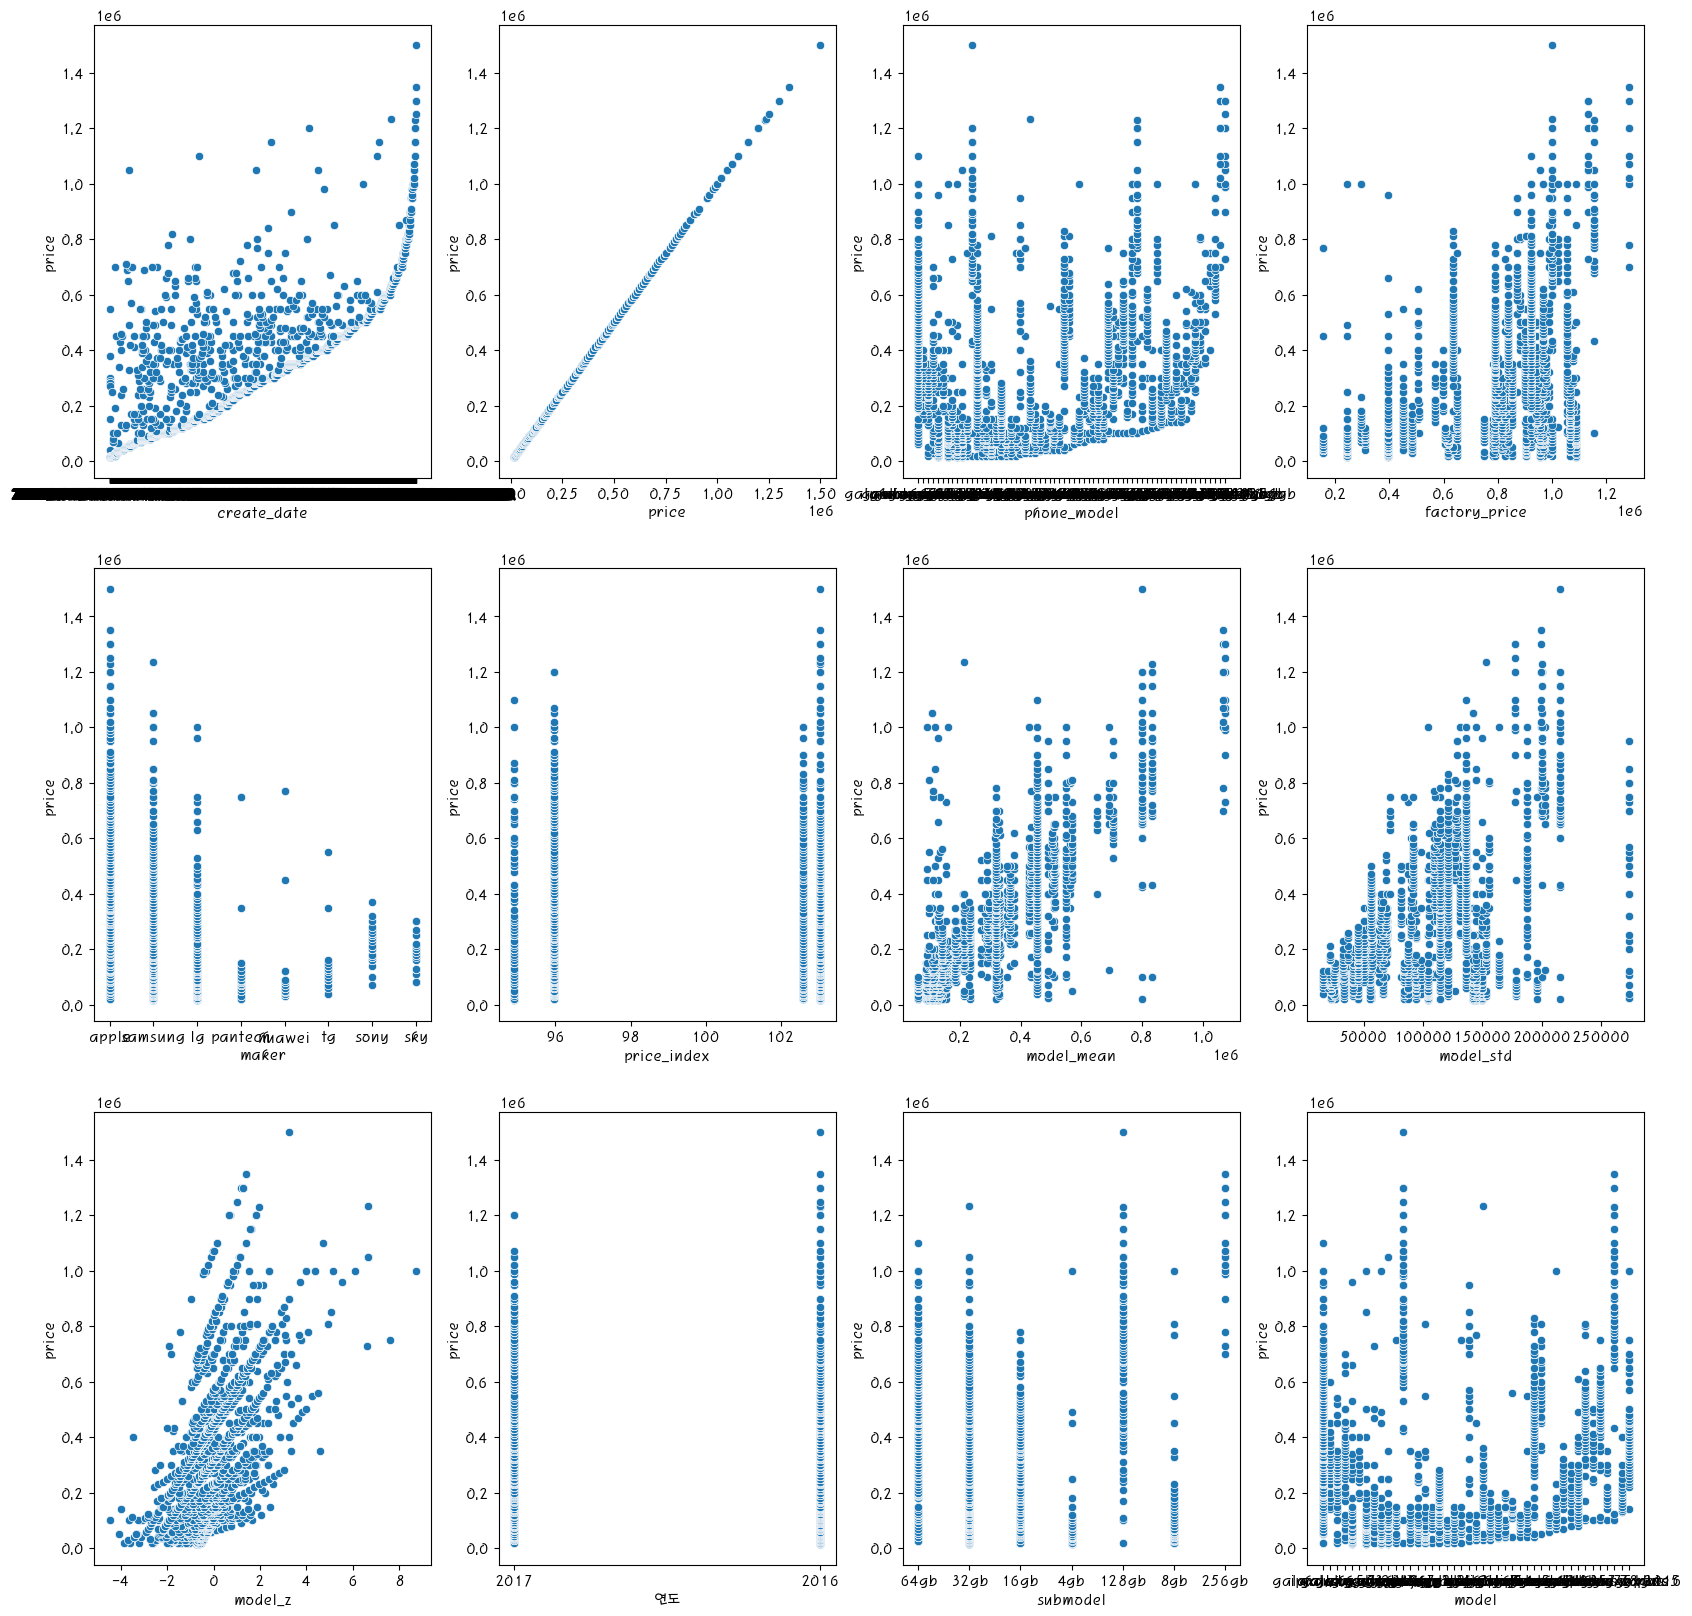

In [30]:
temp  = df.copy()
temp.drop(columns=['text'],inplace=True)
# 3 4
fig,ax = plt.subplots(3,4,figsize=(20,20))
for idx,value in enumerate(temp.columns):    
    sns.scatterplot(data=temp, y='price',x=value,ax=ax[idx//4,idx%4])   
    

In [31]:
# 모델별 text를 분석(빈도, 시각화) VS 가격과 연관이 있는지 확인

In [32]:
temp

,create_date,price,phone_model,factory_price,maker,price_index,model_mean,model_std,model_z,연도,submodel,model
0,2017-03-19 4 35 00 PM,550000.0,iphone 6 64gb,924000,apple,95.96,4.545240e+05,136150.876923,0.701252,2017,64gb,iphone 6
1,2016-10-26 12 08 00 PM,380000.0,galaxy s6 edge 32gb,979000,samsung,103.05,2.972500e+05,64489.613555,1.283152,2016,32gb,galaxy s6 edge
2,2016-10-25 12 52 00 PM,300000.0,galaxy s6 32gb,854000,samsung,103.05,2.346903e+05,55754.897230,1.171372,2016,32gb,galaxy s6
3,2017-03-23 11 14 00 PM,290000.0,lg g5 32gb,836000,lg,95.96,3.300745e+05,121281.535006,-0.330426,2017,32gb,lg g5
4,2016-04-11 7 35 00 PM,280000.0,lg u 32gb,396000,lg,102.59,1.279354e+05,149907.157920,1.014392,2016,32gb,lg u
...,...,...,...,...,...,...,...,...,...,...,...,...
4946,2016-10-10 11 29 00 AM,1300000.0,iphone 7 plus 256gb,1283700,apple,103.05,1.067273e+06,199202.957262,1.168292,2016,256gb,iphone 7 plus
4947,2016-10-24 10 03 00 PM,1300000.0,iphone 7 256gb,1130800,apple,103.05,1.072353e+06,177536.243193,1.282257,2016,256gb,iphone 7
4948,2016-09-19 10 15 00 AM,1300000.0,iphone 7 256gb,1130800,apple,103.05,1.072353e+06,177536.243193,1.282257,2016,256gb,iphone 7
4949,2016-10-05 12 22 00 AM,1350000.0,iphone 7 plus 256gb,1283700,apple,103.05,1.067273e+06,199202.957262,1.419293,2016,256gb,iphone 7 plus


In [33]:
# 전체 텍스트를 분석
# 모델별로...

In [34]:
df.text

0       아이폰6플러스 블랙+애플라이트 64기가 팝니다  아이폰6플러스 블랙+애플라이트 64...
1       갤럭시s6엣지 32기가 팝니다 직거래  갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...
2       갤럭시s6 풀박스로 팝니다~~~ 새상품급  실기스조차 없어요  직접거래 구매한지 1...
3       sk  g5 티탄 폰 단품판매합니다  직접거래 sk g5 티탄 폰 단품판매합니다 올...
4        sony 엑스페리아 c5 ultra e5506 16gb  미사용 새제품 팝니다 1...
                              ...                        
4946    미개봉 언락폰 아이폰7플러스 256gb 골드 iphone7 plus 강북 도봉\t ...
4947    미국판 아이폰7 256g 제트블랙 강남역삼 2대 미개봉언락 애플 a1660 강남역삼...
4948    아이폰7 미개봉 홍콩판 팝니다 케이스,강화유리서비스 종류다양 아이폰7  917,91...
4949    미개봉 언락폰 아이폰7플러스 256gb 골드 iphone7 plus 강북 도봉 미개...
4950     팝니다  아이폰 7 128gb 제트블랙 북미판  카메라 무음, 국내리퍼 가능  1...
Name: text, Length: 4951, dtype: object

In [35]:
# 불용어를 리스트로 정의해서 품사단위로 태깅  Okt   not in 이런거 이용해서 해당 불용얼 리스트에 해당하지 않는 단어추출

In [120]:
def showTextClude(listValue:list, count = 0):
    temp_list = [re.sub(r'[^\w]',' ',w) for w in listValue]
    temp = [i.split() for i in temp_list]
    temp = reduce(lambda x,y : x+y, temp)
    temp = [re.sub(r'[^\w]',' ',w) for w in temp]
    temp =[w for w in temp if len(w) > 1]
    stopword = ['니다','연락','가능','또는','포함','모두','거래','하기','세요','경우','을','는','은','택배']
    temp = [w for w in temp if not np.any([w[-2:] in stopword, w[-1] in stopword])]
    temp_count = Counter(temp)
    if count != 0:     
        temp_count = dict(temp_count.most_common(count)) # 상위 count개
    wc = WordCloud(font_loc ,background_color='white',width=800,height=600)
    cloud = wc.generate_from_frequencies(temp_count)
    plt.imshow(cloud)
    plt.axis('off')
    plt.show()

sky


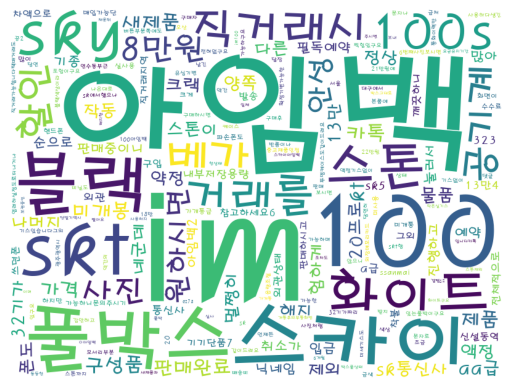

In [130]:
print(df.maker.unique()[7])
showTextClude(df[df.maker == df.maker.unique()[7]].text.values)

In [37]:
nlp = Okt() 

In [39]:
temp = [i.split() for i in temp_list]
temp = reduce(lambda x,y : x+y, temp)
temp = [re.sub(r'[^\w]',' ',w) for w in temp]
temp =[w for w in temp if len(w) > 1]
temp

['아이폰6플러스',
 '블랙',
 '애플라이트',
 '64기가',
 '팝니다',
 '아이폰6플러스',
 '블랙',
 '애플라이트',
 '64기가',
 '팝니다',
 '아이폰6플러스',
 '블랙',
 '애플라이트',
 '64기가',
 '팝니다',
 '리퍼기간이',
 '만료되어서',
 '하우징을',
 '하게되었습니다',
 '상태',
 '초a급',
 '기스도없습니다',
 '아이폰6플러스',
 '블랙',
 '애플라이트',
 '64기가',
 '팝니다',
 '아이폰6플러스',
 '블랙',
 '애플라이트',
 '64기가',
 '팝니다',
 '리퍼기간이',
 '만료되어서',
 '하우징을',
 '하게되었습니다',
 '상태',
 '초a급',
 '기스도없습니다',
 '블랙하우징',
 '애플라이트',
 '골드홈버튼링',
 '골드카메라링',
 '골드볼륨버튼',
 '골드슬립버튼',
 '검금으로',
 '심플하고',
 '튀지않게',
 '이쁘게',
 '했구요유심만',
 '꽂고',
 '바로',
 '사용하시면',
 '됩니다',
 '사람들이',
 '아이폰7이냐고',
 '자주물어보고',
 '실제로보시면',
 '더욱이쁩니다',
 '밤에',
 '영롱하게',
 '맥북처럼',
 '뒷면에',
 '사과로고가',
 '비춰지고요전',
 '아이폰7으로',
 '넘어가기위해서',
 '판매합니다',
 'skt',
 'kt',
 'lg',
 '3사',
 '다가능합니다',
 '박스는',
 '어머니가',
 '버리시고이어폰',
 '충전기',
 'usb',
 '정품으로',
 '모두',
 '드립니다',
 '직거래를',
 '우선순위로하고',
 '정구매하고싶으시면',
 '선입금후',
 '택배로',
 '발송해드리겠습니다',
 '못믿으시면',
 '직거래하시길',
 '추천해요',
 '안전거래',
 '안합니다',
 '지역서울시',
 '강남구',
 '역삼동',
 '차병원사거리',
 '근처가격',
 '55만원',
 '갤럭시s6엣지',
 '32기가',
 '팝니다',
 '직거래',
 '갤럭시s6엣지',
 '32기가',
 '품명',
 '갤럭시s6

In [100]:
# 불용어를 정의하고 제거
stopword = ['니다','연락','가능','또는','포함','모두','거래','하기','세요','경우','을','는','은','택배']
temp = [w for w in temp if not np.any([w[-2:] in stopword, w[-1] in stopword])]
# for w in temp 
# '니다' in '거래합니다'
# '팝니다' in stopword


# not np.any(['팝니다'[-2:] in stopword, '팝니다'[-1] in stopword])
# np.all([True,True])
# temp


In [106]:
temp_count = Counter(temp)
temp_count = dict(temp_count.most_common(50))
temp_count


{'골드': 1652,
 '아이폰6': 1332,
 '아이폰': 1329,
 'lg': 1297,
 '64기가': 1092,
 '64g': 1071,
 '삭제': 958,
 '로즈골드': 958,
 '갤럭시': 947,
 'a급': 944,
 '상태': 924,
 '정상해지': 924,
 'skt': 887,
 '실버': 841,
 '아이폰6s': 829,
 '케이스': 828,
 '화이트': 698,
 '구성품': 669,
 '32g': 664,
 '16g': 650,
 '블랙': 638,
 '풀박스': 621,
 '충전기': 618,
 '16기가': 605,
 '서울': 599,
 '중고나라': 599,
 '공식': 567,
 '다운받기': 556,
 '거래금지': 556,
 '항목': 556,
 '허위작성하거나': 556,
 '임의': 556,
 '채우지': 556,
 '무통보': 556,
 '삭제될수': 556,
 '바로': 553,
 '편한': 549,
 '문자': 529,
 '사진': 520,
 '공기계': 507,
 '찍힘': 505,
 '32기가': 500,
 '같이': 494,
 '사용': 485,
 '64gb': 485,
 '판매': 479,
 's급': 479,
 '플러스': 472,
 '기스': 467,
 'kt': 464}

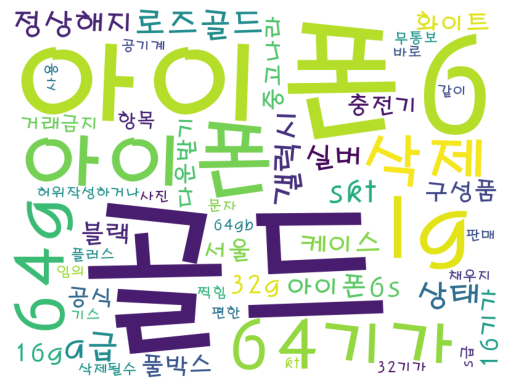

In [107]:
wc = WordCloud(font_loc ,background_color='white',width=800,height=600)
cloud = wc.generate_from_frequencies(temp_count)
plt.imshow(cloud)
plt.axis('off')
plt.show()

In [112]:
df.maker.unique()

array(['apple', 'samsung', 'lg', 'pantech', 'huawei', 'tg', 'sony', 'sky'],
      dtype=object)

In [113]:
# 모델별로. 구름 클라우드

In [114]:
df.head(1)

,create_date,price,text,phone_model,factory_price,maker,price_index,model_mean,model_std,model_z,연도,submodel,model
0,2017-03-19 4 35 00 PM,550000.0,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...,iphone 6 64gb,924000,apple,95.96,454523.974052,136150.876923,0.701252,2017,64gb,iphone 6
